In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib ipympl
import rowan
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy import integrate
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
import pytransform3d.rotations as pr
from utils import calc_quat_angle_error, integrate_angular_velocity, calc_rel_orientation

In [2]:
# train_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/building_10fps/train/airsim_rec.txt', sep="\t")
train_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/building_10fps/val/airsim_rec.txt', sep="\t")

In [ ]:
plt.figure()
ax = plt.axes(projection= '3d')
ax.plot3D(train_data["POS_X"], train_data["POS_Y"], train_data["POS_Z"], label = "AirSim Ground Truth Train Poses", color = 'blue')
ax.plot3D(val_data["POS_X"], val_data["POS_Y"], val_data["POS_Z"], label = "AirSim Ground Truth Test Poses", color = 'red')
ax.set_zlim([-2, -5])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("AirSim Training and Test Trajectories")
ax.legend()
plt.show()

In [3]:
# Calculate timestamp, time from start in seconds, and timestep between imu recordings
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"], unit='ns')
train_data["seconds"] = (train_data["timestamp"] - train_data["timestamp"][0]).dt.total_seconds()
train_data["prev_timestamp"] = train_data["timestamp"].shift(1)
train_data["timestep"] = ((train_data["timestamp"] - train_data["prev_timestamp"]).dt.total_seconds())

# Get previous poses
train_data["prev_Q_W"] = train_data["Q_W"].shift(1)
train_data["prev_Q_X"] = train_data["Q_X"].shift(1)
train_data["prev_Q_Y"] = train_data["Q_Y"].shift(1)
train_data["prev_Q_Z"] = train_data["Q_Z"].shift(1)
train_data["prev_POS_X"] = train_data["POS_X"].shift(1)
train_data["prev_POS_Y"] = train_data["POS_Y"].shift(1)
train_data["prev_POS_Z"] = train_data["POS_Z"].shift(1)

# Get previous angular velocity
train_data["prev_S_ANG_VEL_X"] = train_data["S_ANG_VEL_X"].shift(1)
train_data["prev_S_ANG_VEL_Y"] = train_data["S_ANG_VEL_Y"].shift(1)
train_data["prev_S_ANG_VEL_Z"] = train_data["S_ANG_VEL_Z"].shift(1)

## Distributions

In [ ]:
dataset = train_data 
plt.figure()
plt.hist(dataset["POS_X"], label="POS_X", alpha=0.5)
plt.hist(dataset["POS_Y"], label="POS_Y", alpha=0.5)
plt.hist(dataset["POS_Z"], label="POS_Z", alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("Position Coordinates (m)")
# plt.hist(dataset["noisy_POS_X"], label="POS_X", alpha=0.5)
# plt.hist(dataset["noisy_POS_Y"], label="POS_Y", alpha=0.5)
# plt.hist(dataset["noisy_POS_Z"], label="POS_Z", alpha=0.5)
plt.title('Distribution of Train Set Translations ' + r'$\bf{x}_c$')
plt.legend()
plt.grid()

plt.figure()
plt.hist(dataset["Q_W"], label="Q_W", alpha=0.5)
plt.hist(dataset["Q_X"], label="Q_X", alpha=0.5)
plt.hist(dataset["Q_Y"], label="Q_Y", alpha=0.5)
plt.hist(dataset["Q_Z"], label="Q_Z", alpha=0.5)
# plt.hist(dataset["noisy_Q_W"], label="Q_W", alpha=0.5)
# plt.hist(dataset["noisy_Q_X"], label="Q_X", alpha=0.5)
# plt.hist(dataset["noisy_Q_Y"], label="Q_Y", alpha=0.5)
# plt.hist(dataset["noisy_Q_Z"], label="Q_Z", alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("Quaternion Values")
plt.title('Distribution of Train Set Orientations ' + r'$\bf{q}_c$')
plt.legend()
plt.grid()

In [ ]:
dataset = val_data
plt.figure()
plt.hist(dataset["imu_rel_POS_X"], label="POS_X", alpha=0.5)
plt.hist(dataset["imu_rel_POS_Y"], label="POS_Y", alpha=0.5)
plt.hist(dataset["imu_rel_POS_Z"], label="POS_Z", alpha=0.5)
plt.title('Distribution of Validation Set Translations ' + r'$\bf{x}_c$')
plt.legend()
plt.grid()

plt.figure()
plt.hist(dataset["imu_rel_Q_W"], label="Q_W", alpha=0.5)
plt.hist(dataset["imu_rel_Q_X"], label="Q_X", alpha=0.5)
plt.hist(dataset["imu_rel_Q_Y"], label="Q_Y", alpha=0.5)
plt.hist(dataset["imu_rel_Q_Z"], label="Q_Z", alpha=0.5)

plt.title('Distribution of Validation Set Orientations ' + r'$\bf{q}_c$')
plt.legend()
plt.grid()

## Plot camera orientations

In [ ]:
focal_length = 0.0036
sensor_size = (0.00367, 0.00274)
intrinsic_camera_matrix = np.array([
    [focal_length, 0, sensor_size[0] / 2],
    [0, focal_length, sensor_size[1] / 2],
    [0, 0, 1]
])
plt.figure()
ax = plt.axes(projection= '3d')
for index, row in val_data.iterrows():
    if index % 10 == 0:
        r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
        rotmat = r.as_matrix()
        # rotate to align to axis in pytransform3d
        rotmat2 = pr.matrix_from_euler_xyz(np.array([0, -np.pi/2, -np.pi/2]))
        cam2world = pt.transform_from(rotmat@rotmat2, np.hstack([ row["POS_X"], row["POS_Y"], row["POS_Z"]]))
        # print(np.hstack([ row["POS_X"], row["POS_Y"], row["POS_Z"]]))
        # print(cam2world)
        pc.plot_camera(ax, intrinsic_camera_matrix, cam2world,
                    sensor_size=sensor_size, virtual_image_distance=0.5, color = "red")
    # if index == 0: 
        # break

ax.plot3D(val_data["POS_X"], val_data["POS_Y"], val_data["POS_Z"], label = "GT val", color = 'red')
ax.set_xlim([1, -10])
ax.set_ylim([-10, 0])
ax.set_zlim([-1, -5])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

## Acceleration

In [ ]:
plt.figure()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

In [ ]:
t = train_data["seconds"]
vel_x = integrate.cumtrapz(train_data["LIN_ACC_X"], t, initial=0)
vel_y = integrate.cumtrapz(train_data["LIN_ACC_Y"], t, initial=0)
vel_z = integrate.cumtrapz(train_data["LIN_ACC_Z"], t, initial=0)
plt.figure()
plt.plot(vel_x, label = "vel_x")
plt.plot(vel_y, label = "vel_y")
plt.plot(vel_z, label = "vel_z")
plt.plot(train_data["LIN_VEL_X"], label = "gt_vel_x")
plt.plot(train_data["LIN_VEL_Y"], label = "gt_vel_y")
plt.plot(train_data["LIN_VEL_Z"], label = "gt_vel_z")
plt.legend()

displacement = integrate.cumtrapz(vel_x, t, initial=0)

plt.figure()
plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_X"], label = "POS_X")
plt.legend()

plt.figure()
displacement = integrate.cumtrapz(vel_y, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_Y"], label = "POS_Y")
plt.legend()

plt.figure()
displacement = integrate.cumtrapz(vel_z, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_Z"], label = "POS_Z")
plt.legend()

In [ ]:
train_data["prev_LIN_VEL_X"] = train_data["LIN_VEL_X"].shift(1)
train_data["prev_LIN_VEL_Y"] = train_data["LIN_VEL_Y"].shift(1)
train_data["prev_LIN_VEL_Z"] = train_data["LIN_VEL_Z"].shift(1)
train_data["prev_LIN_ACC_X"] = train_data["LIN_ACC_X"].shift(1)
train_data["prev_LIN_ACC_Y"] = train_data["LIN_ACC_Y"].shift(1)
train_data["prev_LIN_ACC_Z"] = train_data["LIN_ACC_Z"].shift(1)

In [ ]:
def get_imu_pred_pose(prev_location, initial_velocity, cur_accel, timestep):
    return prev_location + initial_velocity * timestep + 1/2 * cur_accel * timestep**2
train_data["imu_pred_POS_X"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_X"], row["prev_LIN_VEL_X"], row["prev_LIN_ACC_X"], row["seconds"]), axis=1)
train_data["imu_pred_POS_Y"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_Y"], row["prev_LIN_VEL_Y"], row["prev_LIN_ACC_Y"], row["seconds"]), axis=1)
train_data["imu_pred_POS_Z"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_Z"], row["prev_LIN_VEL_Z"], row["prev_LIN_ACC_Z"], row["seconds"]), axis=1)

In [ ]:
plt.figure()
train_data["POS_X"].plot()
train_data["imu_pred_POS_X"].plot()

plt.figure()
train_data["POS_Y"].plot()
train_data["imu_pred_POS_Y"].plot()

plt.figure()
train_data["POS_Z"].plot()
train_data["imu_pred_POS_Z"].plot()
plt.legend()

## Angular Velocity

In [ ]:
train_data.fillna(0, inplace =True)
train_data.head()

In [ ]:
train_data["pred_Q_W"] = train_data.apply(lambda row: integrate_angular_velocity(
                                            rowan.normalize(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]])),
                                            np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]), 
                                            row["timestep"])[0], axis=1)
train_data["pred_Q_X"] = train_data.apply(lambda row: integrate_angular_velocity(
                                            rowan.normalize(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]])),
                                            np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]), 
                                            row["timestep"])[1], axis=1)
train_data["pred_Q_Y"] = train_data.apply(lambda row: integrate_angular_velocity(
                                            rowan.normalize(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]])),
                                            np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]), 
                                            row["timestep"])[2], axis=1)
train_data["pred_Q_Z"] = train_data.apply(lambda row: integrate_angular_velocity(
                                            rowan.normalize(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]])),
                                            np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]), 
                                            row["timestep"])[3], axis=1)

In [ ]:
def convert_quat_to_euler(row, pred=False):
	if pred:
		r = R.from_quat(np.hstack([row["pred_Q_X"], row["pred_Q_Y"], row["pred_Q_Z"], row["pred_Q_W"]]))
	else:
		r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
	return r.as_euler('xyz', degrees = True) #extrinsic rotation (Fixed frame)

train_data["roll"] = train_data.apply(lambda row: convert_quat_to_euler(row)[0], axis=1)
train_data["pitch"] =train_data.apply(lambda row: convert_quat_to_euler(row)[1], axis=1) 
train_data["yaw"] = train_data.apply(lambda row: convert_quat_to_euler(row)[2], axis=1)
train_data["pred_roll"] = train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[0], axis=1)
train_data["pred_pitch"] =train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[1], axis=1) 
train_data["pred_yaw"] = train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[2], axis=1)

plt.figure()
train_data["roll"].plot()
train_data["pitch"].plot()
train_data["yaw"].plot()
plt.legend(["roll", "pitch", "yaw"])

plt.figure()
train_data["pred_roll"].plot()
train_data["pred_pitch"].plot()
train_data["pred_yaw"].plot()
plt.legend(["roll", "pitch", "yaw"])

## Handling IMU

In [4]:
np.random.seed(123)

In [5]:
# noise_x = np.random.normal(0,0.5,len(train_data))
# noise_y = np.random.normal(0,0.5,len(train_data))
# noise_z = np.random.normal(0,0.1,len(train_data))
# noise_x = np.random.normal(0,0.8,len(train_data))
# noise_y = np.random.normal(0,0.8,len(train_data))
# noise_z = np.random.normal(0,0.2,len(train_data))
noise_x = 0
noise_y = 0
noise_z = 0
train_data["noisy_POS_X"] = noise_x + train_data["POS_X"]
train_data["noisy_POS_Y"] = noise_y + train_data["POS_Y"]
train_data["noisy_POS_Z"] = noise_z + train_data["POS_Z"]

train_data["noisy_prev_POS_X"] = train_data["noisy_POS_X"].shift(1)
train_data["noisy_prev_POS_Y"] = train_data["noisy_POS_Y"].shift(1)
train_data["noisy_prev_POS_Z"] = train_data["noisy_POS_Z"].shift(1)

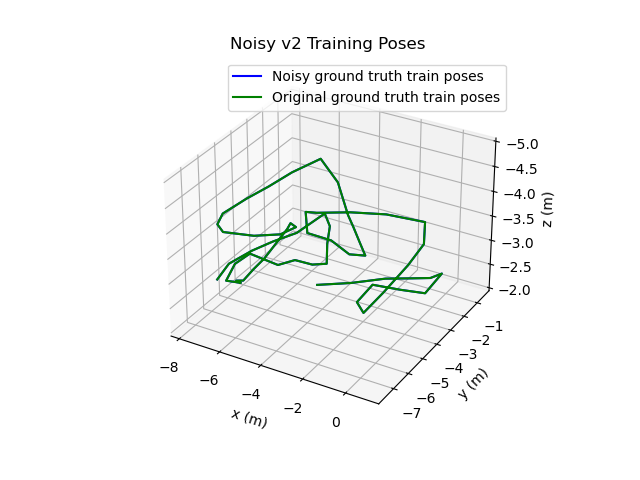

In [6]:
plt.figure()
step = 100
ax = plt.axes(projection= '3d')
ax.plot3D(train_data["noisy_POS_X"].iloc[step::step], train_data["noisy_POS_Y"].iloc[step::step], train_data["noisy_POS_Z"].iloc[step::step], label = "Noisy ground truth train poses", color = 'blue')
ax.plot3D(train_data["POS_X"].iloc[step::step], train_data["POS_Y"].iloc[step::step], train_data["POS_Z"].iloc[step::step], label = "Original ground truth train poses", color = 'Green')
ax.set_zlim([-2, -5])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Noisy v2 Training Poses")
ax.legend()
plt.show()

In [7]:
# noise_qw = np.random.normal(0,0.01,len(train_data))
# noise_qx = np.random.normal(0,0.01,len(train_data))
# noise_qy = np.random.normal(0,0.01,len(train_data))
# noise_qz = np.random.normal(0,0.01,len(train_data))
# noise_qw = np.random.normal(0,0.02,len(train_data))
# noise_qx = np.random.normal(0,0.02,len(train_data))
# noise_qy = np.random.normal(0,0.02,len(train_data))
# noise_qz = np.random.normal(0,0.02,len(train_data))
noise_qw = 0
noise_qx = 0
noise_qy = 0
noise_qz = 0
train_data["noisy_Q_W"] = noise_qw + train_data["Q_W"]
train_data["noisy_Q_X"] = noise_qx + train_data["Q_X"]
train_data["noisy_Q_Y"] = noise_qy + train_data["Q_Y"]
train_data["noisy_Q_Z"] = noise_qz + train_data["Q_Z"]

# Ensure that noisy quaternions is a valid rotation
normalized_q = pd.DataFrame(rowan.normalize(train_data[["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"]]), columns=["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"])
train_data["noisy_Q_W"] = normalized_q["noisy_Q_W"]
train_data["noisy_Q_X"] = normalized_q["noisy_Q_X"]
train_data["noisy_Q_Y"] = normalized_q["noisy_Q_Y"]
train_data["noisy_Q_Z"] = normalized_q["noisy_Q_Z"]

train_data["noisy_prev_Q_W"] = train_data["noisy_Q_W"].shift(1)
train_data["noisy_prev_Q_X"] = train_data["noisy_Q_X"].shift(1)
train_data["noisy_prev_Q_Y"] = train_data["noisy_Q_Y"].shift(1)
train_data["noisy_prev_Q_Z"] = train_data["noisy_Q_Z"].shift(1)

In [8]:
err =[]
for idx, row, in train_data.iterrows():
    err.append(np.linalg.norm(np.array(row[["noisy_POS_X", "noisy_POS_Y", "noisy_POS_Z"]]) - np.array(row[["POS_X", "POS_Y", "POS_Z"]])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

q_err = train_data.apply(lambda row: 
                        calc_quat_angle_error(
                            np.hstack([row["noisy_Q_W"], row["noisy_Q_X"], row["noisy_Q_Y"], row["noisy_Q_Z"]]),
                            np.hstack([row["Q_W"], row["Q_X"], row["Q_Y"], row["Q_Z"]])
                        ), axis=1)
print(f'Orientation error {np.median(q_err)} (median) deg, {np.mean(q_err)} (mean) deg')

Translation error 0.0 (median) m, 0.0 (mean) m
Orientation error 0.0 (median) deg, 1.3261550253915886e-07 (mean) deg


In [9]:
def convert_body_to_world(row):
	body_acc = np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float)
	r = R.from_quat(np.hstack([row["noisy_Q_X"], row["noisy_Q_Y"], row["noisy_Q_Z"], row["noisy_Q_W"]]))
	world_acc = r.apply(body_acc)
	return world_acc - np.array([0, 0, -9.81])

# Convert imu linear acceleration from body frame to world frame
train_data["S_LIN_ACC_X_world"] = train_data.apply(lambda row : convert_body_to_world(row)[0], axis = 1)
train_data["S_LIN_ACC_Y_world"] = train_data.apply(lambda row : convert_body_to_world(row)[1], axis = 1)
train_data["S_LIN_ACC_Z_world"] = train_data.apply(lambda row : convert_body_to_world(row)[2], axis = 1)

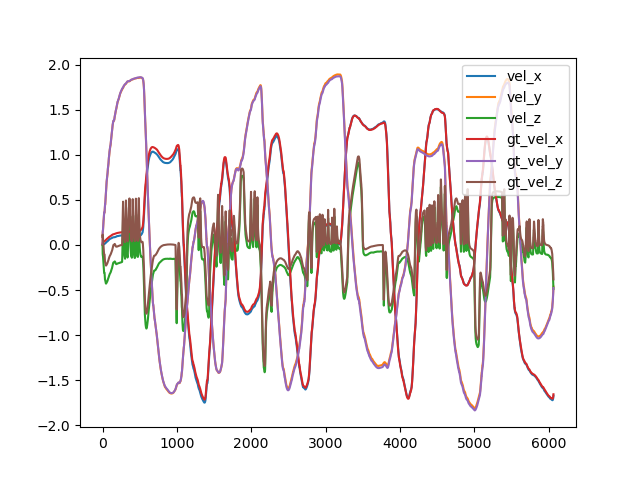

In [10]:
plt.figure()
t = train_data["seconds"]
vel_x = integrate.cumtrapz(train_data["S_LIN_ACC_X_world"], t, initial=0)
vel_y = integrate.cumtrapz(train_data["S_LIN_ACC_Y_world"], t, initial=0)
vel_z = integrate.cumtrapz(train_data["S_LIN_ACC_Z_world"], t, initial=0) 
plt.plot(vel_x, label = "vel_x")
plt.plot(vel_y, label = "vel_y")
plt.plot(vel_z, label = "vel_z")
plt.plot(train_data["LIN_VEL_X"], label = "gt_vel_x")
plt.plot(train_data["LIN_VEL_Y"], label = "gt_vel_y")
plt.plot(train_data["LIN_VEL_Z"], label = "gt_vel_z")
plt.legend()

In [11]:
# Get imu linear velocity integrated using imu acceleration corrected using noisy orientation
train_data["S_LIN_VEL_X"] = vel_x
train_data["S_LIN_VEL_Y"] = vel_y
train_data["S_LIN_VEL_Z"] = vel_z
train_data["prev_S_LIN_VEL_X"] = train_data["S_LIN_VEL_X"].shift(1)
train_data["prev_S_LIN_VEL_Y"] = train_data["S_LIN_VEL_Y"].shift(1)
train_data["prev_S_LIN_VEL_Z"] = train_data["S_LIN_VEL_Z"].shift(1)

train_data["S_LIN_ACC_X"] = train_data["S_LIN_ACC_X_world"]
train_data["S_LIN_ACC_Y"] = train_data["S_LIN_ACC_Y_world"]
train_data["S_LIN_ACC_Z"] = train_data["S_LIN_ACC_Z_world"]
train_data["prev_S_LIN_ACC_X"] = train_data["S_LIN_ACC_X"].shift(1)
train_data["prev_S_LIN_ACC_Y"] = train_data["S_LIN_ACC_Y"].shift(1)
train_data["prev_S_LIN_ACC_Z"] = train_data["S_LIN_ACC_Z"].shift(1)


In [12]:
train_data.head()

,Vehicle_name,timestamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,LIN_ACC_X,...,S_LIN_ACC_Z_world,S_LIN_VEL_X,S_LIN_VEL_Y,S_LIN_VEL_Z,prev_S_LIN_VEL_X,prev_S_LIN_VEL_Y,prev_S_LIN_VEL_Z,prev_S_LIN_ACC_X,prev_S_LIN_ACC_Y,prev_S_LIN_ACC_Z
0,,2022-06-09 18:06:59.579603968,-7.015162,-7.301315,-2.835621,0.999996,0.001988,-0.002065,0.000018,0.036016,...,0.075517,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-06-09 18:06:59.734094080,-7.013433,-7.264459,-2.805459,0.997178,0.067249,-0.007290,0.032564,0.112656,...,-1.203183,-0.005238,0.121516,-0.087107,0.000000,0.000000,0.000000,-0.078661,0.089634,0.075517
2,,2022-06-09 18:06:59.743093504,-7.013474,-7.259759,-2.803750,0.996889,0.069451,-0.007746,0.036457,0.116195,...,-1.258987,-0.004730,0.134990,-0.098186,-0.005238,0.121516,-0.087107,0.010855,1.483484,-1.203183
3,,2022-06-09 18:06:59.753592832,-7.013564,-7.253902,-2.801845,0.996533,0.071787,-0.008300,0.041239,0.120054,...,-1.515036,-0.003294,0.151414,-0.112748,-0.004730,0.134990,-0.098186,0.101901,1.511118,-1.258987
4,,2022-06-09 18:06:59.759592448,-7.013639,-7.250373,-2.800805,0.996319,0.073015,-0.008625,0.044086,0.122137,...,-1.408096,-0.002447,0.161382,-0.121517,-0.003294,0.151414,-0.112748,0.171747,1.617368,-1.515036


## Obtaining Absolute Pose

### Method 1
always start with COLMAP positions and integrate with imu in between

In [ ]:
results = []
step = 100
for i in range(step, len(train_data), step):
    x = train_data.iloc[i - step, :].noisy_POS_X
    y = train_data.iloc[i - step, :].noisy_POS_Y
    z = train_data.iloc[i - step, :].noisy_POS_Z
    for j in range(i - step + 1, i + 1):
        row = train_data.iloc[j, :]
        x += row.prev_S_LIN_VEL_X * row.timestep + 1/2 * row.prev_S_LIN_ACC_X * row.timestep ** 2 
        y += row.prev_S_LIN_VEL_Y * row.timestep + 1/2 * row.prev_S_LIN_ACC_Y * row.timestep ** 2 
        z += row.prev_S_LIN_VEL_Z * row.timestep + 1/2 * row.prev_S_LIN_ACC_Z * row.timestep ** 2
    results.append([x, y, z])

df1 = pd.DataFrame(results, columns=["imu_POS_X", "imu_POS_Y","imu_POS_Z"])
df1["idx"] = [i for i in range(step, len(train_data), step)]
df1.set_index("idx", inplace=True)

### Method 2
Start and End with average

In [ ]:
test_df = train_data.iloc[:-1, :]

In [ ]:
results = []
step = 100
for i in range(step, len(test_df), step):
    # print("predicting for", i)
    x = test_df.iloc[i - step, :].noisy_POS_X
    y = test_df.iloc[i - step, :].noisy_POS_Y
    z = test_df.iloc[i - step, :].noisy_POS_Z
    # print(f"x, y, z at {i-step} is {x}, {y}, {z}")
    if results: 
        imu_x, imu_y, imu_z = results[-1]
        # print(f'imu pred is {imu_x, imu_y, imu_z}')
        x = (imu_x + x)/2
        x = (imu_y + y)/2
        x = (imu_z + z)/2
    for j in range(i - step + 1, i + 1):
        row = test_df.iloc[j, :]
        x += row.prev_S_LIN_VEL_X * row.timestep + 1/2 * row.prev_S_LIN_ACC_X * row.timestep ** 2 
        y += row.prev_S_LIN_VEL_Y * row.timestep + 1/2 * row.prev_S_LIN_ACC_Y * row.timestep ** 2 
        z += row.prev_S_LIN_VEL_Z * row.timestep + 1/2 * row.prev_S_LIN_ACC_Z * row.timestep ** 2
    x = (x + test_df.iloc[i, :].noisy_POS_X) / 2
    y = (y + test_df.iloc[i, :].noisy_POS_Y) / 2
    z = (z + test_df.iloc[i, :].noisy_POS_Z) / 2
    
    results.append([x, y, z])
df2 = pd.DataFrame(results, columns=["imu_POS_X", "imu_POS_Y","imu_POS_Z"])
df2["idx"] = [i for i in range(step, len(test_df), step)]
df2.set_index("idx", inplace=True)

In [ ]:
alt_results = []
step = 100
for i in range(step, len(test_df), step):
    x = test_df.iloc[i - step, :].POS_X
    y = test_df.iloc[i - step, :].POS_Y
    z = test_df.iloc[i - step, :].POS_Z

    for j in range(i - step + 1, i + 1):
        row = train_data.iloc[j, :]
        x += row.prev_S_LIN_VEL_X * row.timestep + 1/2 * row.prev_S_LIN_ACC_X * row.timestep ** 2 
        y += row.prev_S_LIN_VEL_Y * row.timestep + 1/2 * row.prev_S_LIN_ACC_Y * row.timestep ** 2 
        z += row.prev_S_LIN_VEL_Z * row.timestep + 1/2 * row.prev_S_LIN_ACC_Z * row.timestep ** 2
    alt_results.append([x, y, z])
alt_df = pd.DataFrame(alt_results, columns=["imu_POS_X", "imu_POS_Y","imu_POS_Z"])
alt_df["idx"] = [i for i in range(step, len(test_df), step)]
alt_df.set_index("idx", inplace=True)

In [ ]:
plt.figure()
plt.plot(test_df["POS_X"], label="True POS_X", marker = '.')
plt.plot(test_df["noisy_POS_X"], label="Noisy POS_X", marker = '.')
plt.plot(df2["imu_POS_X"], label="Average POS_X", marker = '.')
plt.plot(alt_df["imu_POS_X"], label="Without Average POS_X", marker = '.')
plt.legend()

plt.figure()
plt.plot(test_df["POS_Y"], label="True POS_Y", marker = '.')
plt.plot(test_df["noisy_POS_Y"], label="Noisy POS_Y", marker = '.')
plt.plot(df2["imu_POS_Y"], label="Average POS_Y", marker = '.')
plt.plot(alt_df["imu_POS_Y"], label="Without Average POS_Y", marker = '.')
plt.legend()

plt.figure()
plt.plot(test_df["POS_Z"], label="True POS_Z", marker = '.')
plt.plot(test_df["noisy_POS_Z"], label="Noisy POS_Z", marker = '.')
plt.plot(df2["imu_POS_Z"], label="Average POS_Z", marker = '.')
plt.plot(alt_df["imu_POS_Z"], label="Without Average POS_Z", marker = '.')
plt.legend()

### Just IMU
Just integrate IMU

In [ ]:
x = train_data.iloc[i - step, :].POS_X
y = train_data.iloc[i - step, :].POS_Y
z = train_data.iloc[i - step, :].POS_Z
results = [[x,y,z]]
step = 100
for i in range(step, len(train_data), step):
    x, y, z = results[-1]
    for j in range(i - step + 1, i + 1):
        row = train_data.iloc[j, :]
        x += row.prev_S_LIN_VEL_X * row.timestep + 1/2 * row.prev_S_LIN_ACC_X * row.timestep ** 2 
        y += row.prev_S_LIN_VEL_Y * row.timestep + 1/2 * row.prev_S_LIN_ACC_Y * row.timestep ** 2 
        z += row.prev_S_LIN_VEL_Z * row.timestep + 1/2 * row.prev_S_LIN_ACC_Z * row.timestep ** 2
    results.append([x, y, z])

df3 = pd.DataFrame(results[1:], columns=["imu_POS_X", "imu_POS_Y","imu_POS_Z"])
df3["idx"] = [i for i in range(step, len(train_data), step)]
df3.set_index("idx", inplace=True)


In [ ]:
plt.figure()
plt.plot(train_data["POS_X"], label="True POS_X", marker = '.')
plt.plot(df3["imu_POS_X"], label="Average POS_X", marker = '.')
plt.legend()

plt.figure()
plt.plot(train_data["POS_Y"], label="True POS_Y", marker = '.')
plt.plot(df3["imu_POS_Y"], label="Average POS_Y", marker = '.')
plt.legend()

plt.figure()
plt.plot(train_data["POS_Z"], label="True POS_Z", marker = '.')
plt.plot(df3["imu_POS_Z"], label="Average POS_Z", marker = '.')
plt.legend()

In [ ]:
print("Just COLMAP")
err =[]
for i in range(len(df2)):
    err.append(np.linalg.norm(np.array(train_data[["noisy_POS_X", "noisy_POS_Y", "noisy_POS_Z"]].iloc[(i+1) * step,:]) - np.array(train_data[["POS_X", "POS_Y", "POS_Z"]].iloc[(i+1) * step,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

print("Just IMU")
err =[]
for i in range(len(df3)):
    err.append(np.linalg.norm(np.array(df3[["imu_POS_X", "imu_POS_Y", "imu_POS_Z"]].iloc[i,:]) - np.array(train_data[["POS_X", "POS_Y", "POS_Z"]].iloc[(i+1) * step,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

print("Method 1")
err =[]
for i in range(len(df1)):
    err.append(np.linalg.norm(np.array(df1[["imu_POS_X", "imu_POS_Y", "imu_POS_Z"]].iloc[i,:]) - np.array(train_data[["POS_X", "POS_Y", "POS_Z"]].iloc[(i+1) * step,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

print("Method 2")
err =[]
for i in range(len(df2)):
    err.append(np.linalg.norm(np.array(df2[["imu_POS_X", "imu_POS_Y", "imu_POS_Z"]].iloc[i,:]) - np.array(train_data[["POS_X", "POS_Y", "POS_Z"]].iloc[(i+1) * step,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

## Obtaining Relative Pose

#### Just using COLMAP

In [13]:
k  = 100
image_frame_step = 10

In [14]:
results = []
for i in range(k, len(train_data), image_frame_step):
    x = train_data.iloc[i, :].noisy_POS_X - train_data.iloc[i - k, :].noisy_POS_X
    y = train_data.iloc[i, :].noisy_POS_Y - train_data.iloc[i - k, :].noisy_POS_Y
    z = train_data.iloc[i, :].noisy_POS_Z - train_data.iloc[i - k, :].noisy_POS_Z

    results.append([x, y, z])

noisy_rel_trans = pd.DataFrame(results, columns=["rel_POS_X", "rel_POS_Y","rel_POS_Z"])
noisy_rel_trans["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
noisy_rel_trans.set_index("idx", inplace=True)

#### Just IMU

In [15]:
results = []
for i in range(k, len(train_data), image_frame_step):
    x = y = z = 0
    for j in range(i - k + 1, i + 1):
        row = train_data.iloc[j, :]
        x += row.prev_S_LIN_VEL_X * row.timestep + 1/2 * row.prev_S_LIN_ACC_X * row.timestep ** 2 
        y += row.prev_S_LIN_VEL_Y * row.timestep + 1/2 * row.prev_S_LIN_ACC_Y * row.timestep ** 2 
        z += row.prev_S_LIN_VEL_Z * row.timestep + 1/2 * row.prev_S_LIN_ACC_Z * row.timestep ** 2
    results.append([x, y, z])

imu_rel_trans = pd.DataFrame(results, columns=["imu_rel_POS_X", "imu_rel_POS_Y","imu_rel_POS_Z"])
imu_rel_trans["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
imu_rel_trans.set_index("idx", inplace=True)

<AxesSubplot:xlabel='idx'>

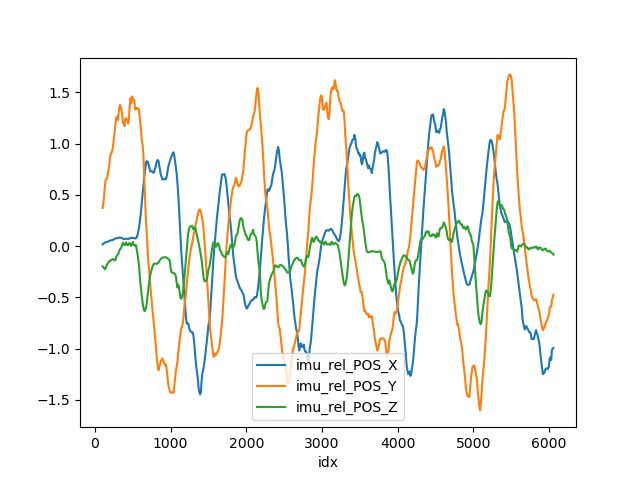

In [16]:
imu_rel_trans.plot()

In [17]:
# True relative translation
train_data["rel_POS_X"] = train_data["POS_X"] - train_data["POS_X"].shift(k)
train_data["rel_POS_Y"] = train_data["POS_Y"] - train_data["POS_Y"].shift(k)
train_data["rel_POS_Z"] = train_data["POS_Z"] - train_data["POS_Z"].shift(k)

print("Just COLMAP")
err =[]
for i in range(len(noisy_rel_trans)):
    err.append(np.linalg.norm(np.array(noisy_rel_trans[["rel_POS_X", "rel_POS_Y","rel_POS_Z"]].iloc[i,:]) - np.array(train_data[["rel_POS_X", "rel_POS_Y", "rel_POS_Z"]].iloc[k + i * image_frame_step,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

print("Just IMU")
err =[]
for i in range(len(imu_rel_trans)):
    err.append(np.linalg.norm(np.array(imu_rel_trans[["imu_rel_POS_X", "imu_rel_POS_Y","imu_rel_POS_Z"]].iloc[i,:]) - np.array(train_data[["rel_POS_X", "rel_POS_Y", "rel_POS_Z"]].iloc[k + i * image_frame_step,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')


Just COLMAP
Translation error 0.0 (median) m, 0.0 (mean) m
Just IMU
Translation error 0.19530632141172402 (median) m, 0.30063877179323695 (mean) m


In [18]:
train_data["imu_rel_POS_X"] = imu_rel_trans["imu_rel_POS_X"]
train_data["imu_rel_POS_Y"] = imu_rel_trans["imu_rel_POS_Y"]
train_data["imu_rel_POS_Z"] = imu_rel_trans["imu_rel_POS_Z"]
train_data["imu_POS_X"] = train_data["noisy_POS_X"] + train_data["imu_rel_POS_X"]
train_data["imu_POS_Y"] = train_data["noisy_POS_Y"] + train_data["imu_rel_POS_Y"]
train_data["imu_POS_Z"] = train_data["noisy_POS_Z"] + train_data["imu_rel_POS_Z"]


<AxesSubplot:>

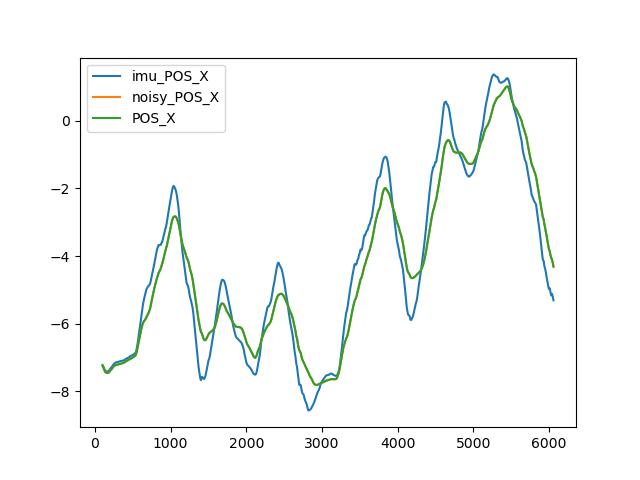

In [19]:
train_data[["imu_POS_X", "noisy_POS_X", "POS_X"]][k::image_frame_step].plot()

## Obtain Absolute Orientation

### Rowan Integration

In [ ]:
results = []
for i in range(k, len(train_data), image_frame_step):
    qw = train_data.iloc[i - k, :].noisy_Q_W
    qx = train_data.iloc[i - k, :].noisy_Q_X
    qy = train_data.iloc[i - k, :].noisy_Q_Y
    qz = train_data.iloc[i - k, :].noisy_Q_Z
    for j in range(i - k + 1, i + 1):
        row = train_data.iloc[j, :]
        qw, qx, qy, qz = rowan.normalize(integrate_angular_velocity(rowan.normalize(np.hstack([qw, qx, qy, qz])),
                                                    np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]),
                                                    row["timestep"]))
    results.append([qw, qx, qy, qz])

In [ ]:
imu_q_rowan = pd.DataFrame(results, columns=["imu_Q_W", "imu_Q_X", "imu_Q_Y", "imu_Q_Z"])
imu_q_rowan["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
imu_q_rowan.set_index("idx", inplace=True)

In [ ]:
plt.figure()
plt.plot(imu_q_rowan["imu_Q_W"], label = "imu qw")
plt.plot(imu_q_rowan["imu_Q_X"], label = "imu qx")
plt.plot(imu_q_rowan["imu_Q_Y"], label = "imu qy")
plt.plot(imu_q_rowan["imu_Q_Z"], label = "imu qz")
plt.plot(train_data["Q_W"], label = "qw")
plt.plot(train_data["Q_X"], label = "qx")
plt.plot(train_data["Q_Y"], label = "qy")
plt.plot(train_data["Q_Z"], label = "qz")
plt.legend()

### AHRS Integration

In [20]:
from ahrs.filters import AngularRate
results = []
for i in range(k, len(train_data), image_frame_step):
    qw = train_data.iloc[i - k, :].noisy_Q_W
    qx = train_data.iloc[i - k, :].noisy_Q_X
    qy = train_data.iloc[i - k, :].noisy_Q_Y
    qz = train_data.iloc[i - k, :].noisy_Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    cur_q = q_prev
    angular_rate = AngularRate()
    for j in range(i - k + 1, i + 1):
        row = train_data.iloc[j, :]
        cur_q = angular_rate.update(cur_q, 
                                    np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]),
                                    'closed', 
                                    1,
                                    row['timestep'])
        cur_q = rowan.normalize(cur_q)
    results.append(cur_q)

In [21]:
imu_q_ahrs = pd.DataFrame(results, columns=["imu_Q_W", "imu_Q_X", "imu_Q_Y", "imu_Q_Z"])
imu_q_ahrs["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
imu_q_ahrs.set_index("idx", inplace=True)

In [22]:
def calc_quat_angle_error_single(label, pred):
    q1 = np.array(pred / np.linalg.norm(pred))
    q2 = np.array(label / np.linalg.norm(label))
    d = np.abs(np.sum(np.multiply(q1,q2))) # Here we have abs()

    d = np.clip(d, a_min=-1, a_max=1)
    error = 2 * np.degrees(np.arccos(d))
    return error

print("Just COLMAP")
axis_angle_err =[]
for i in range(len(imu_q_ahrs)):
    axis_angle_err.append(
        calc_quat_angle_error_single(train_data[["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"]].iloc[k + i * image_frame_step,:],
                                    train_data[["Q_W", "Q_X", "Q_Y", "Q_Z"]].iloc[k + i * image_frame_step,:])
    )
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

print("AHRS")
axis_angle_err =[]
for i in range(len(imu_q_ahrs)):
    axis_angle_err.append(
        calc_quat_angle_error_single(imu_q_ahrs[["imu_Q_W", "imu_Q_X", "imu_Q_Y", "imu_Q_Z"]].iloc[i,:],
                                    train_data[["Q_W", "Q_X", "Q_Y", "Q_Z"]].iloc[k + i * image_frame_step,:])
    )
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

Just COLMAP
Orientation error 0.0 (median) deg, 1.9273482804945608e-07 (mean) deg
AHRS
Orientation error 0.24821501531786314 (median) deg, 0.31150114904346926 (mean) deg


In [23]:
print(np.mean((imu_q_ahrs["imu_Q_X"]- train_data["Q_X"])**2))
print(np.mean((train_data["noisy_Q_X"]- train_data["Q_X"])**2))

0.0007326924265833132
5.3224614352439825e-18


In [24]:
train_data["imu_Q_W"] = imu_q_ahrs["imu_Q_W"]
train_data["imu_Q_X"] = imu_q_ahrs["imu_Q_Y"]
train_data["imu_Q_Y"] = imu_q_ahrs["imu_Q_X"]
train_data["imu_Q_Z"] = imu_q_ahrs["imu_Q_Z"]


## Obtain Relative Orientation

In [ ]:
results = []
step = 100
for i in range(step, len(train_data), step):
    qw = train_data.iloc[i - step, :].noisy_Q_W
    qx = train_data.iloc[i - step, :].noisy_Q_X
    qy = train_data.iloc[i - step, :].noisy_Q_X
    qz = train_data.iloc[i - step, :].noisy_Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    cur_q = q_prev
    for j in range(i - step + 1, i + 1):
        row = train_data.iloc[j, :]
        cur_q = rowan.calculus.integrate(rowan.normalize(cur_q), 
                                          np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]), 
                                          row["timestep"])
    rel_q = calc_rel_orientation(q_prev, cur_q)
    results.append(rel_q)

In [ ]:
df_test = pd.DataFrame(results, columns=["imu_rel_Q_W", "imu_rel_Q_X", "imu_rel_Q_Y", "imu_rel_Q_Z"])
df_test["idx"] = [i for i in range(step, len(train_data), step)]
df_test.set_index("idx", inplace=True)

In [ ]:
results = []
step = 100
for i in range(step, len(train_data), step):
    qw = train_data.iloc[i - step, :].noisy_Q_W
    qx = train_data.iloc[i - step, :].noisy_Q_X
    qy = train_data.iloc[i - step, :].noisy_Q_X
    qz = train_data.iloc[i - step, :].noisy_Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    cur_q = q_prev
    angular_rate = AngularRate()
    for j in range(i - step + 1, i + 1):
        row = train_data.iloc[j, :]
        cur_q = angular_rate.update(cur_q, 
                                    np.hstack([row["prev_S_ANG_VEL_X"],row["prev_S_ANG_VEL_Y"], row["prev_S_ANG_VEL_Z"]]),
                                    'closed', 
                                    1)

    rel_q = calc_rel_orientation(q_prev, cur_q)
    results.append(rel_q)

In [ ]:
df_test2 = pd.DataFrame(results, columns=["imu_rel_Q_W", "imu_rel_Q_X", "imu_rel_Q_Y", "imu_rel_Q_Z"])
df_test2["idx"] = [i for i in range(step, len(train_data), step)]
df_test2.set_index("idx", inplace=True)
df_test2.plot()

### Just COLMAP

In [ ]:
from ahrs.filters import AngularRate
results = []
step = 100
for i in range(step, len(train_data), step):
    qw = train_data.iloc[i - step, :].noisy_Q_W
    qx = train_data.iloc[i - step, :].noisy_Q_X
    qy = train_data.iloc[i - step, :].noisy_Q_X
    qz = train_data.iloc[i - step, :].noisy_Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    qw = train_data.iloc[i, :].noisy_Q_W
    qx = train_data.iloc[i, :].noisy_Q_X
    qy = train_data.iloc[i, :].noisy_Q_X
    qz = train_data.iloc[i, :].noisy_Q_Z
    q = np.array([qw, qx, qy, qz]) 
    
    results.append(calc_rel_orientation(q_prev, q))
df2 = pd.DataFrame(results, columns=["rel_Q_W", "rel_Q_X", "rel_Q_Y", "rel_Q_Z"])
df2["idx"] = [i for i in range(step, len(train_data), step)]
df2.set_index("idx", inplace=True)

In [ ]:
df2.plot()

In [ ]:
df = pd.DataFrame()
df["Q_W"] = train_data["Q_W"][step::step]
df["Q_X"] = train_data["Q_X"][step::step]
df["Q_Y"] = train_data["Q_Y"][step::step]
df["Q_Z"] = train_data["Q_Z"][step::step]
true_rel_orientation = []
for i in range(step, len(train_data), step):
    qw = train_data.iloc[i - step, :].Q_W
    qx = train_data.iloc[i - step, :].Q_X
    qy = train_data.iloc[i - step, :].Q_X
    qz = train_data.iloc[i - step, :].Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    qw = train_data.iloc[i, :].Q_W
    qx = train_data.iloc[i, :].Q_X
    qy = train_data.iloc[i, :].Q_X
    qz = train_data.iloc[i, :].Q_Z
    q = np.array([qw, qx, qy, qz]) 
    
    true_rel_orientation.append(calc_rel_orientation(q_prev, q))
true_rel = pd.DataFrame(true_rel_orientation, columns=["true_rel_Q_W", "true_rel_Q_X", "true_rel_Q_Y", "true_rel_Q_Z"])
true_rel["idx"] = [i for i in range(step, len(train_data), step)]
true_rel.set_index("idx", inplace=True)

In [ ]:
true_rel.plot()

In [ ]:
print("Just COLMAP")
df2 = pd.concat([df2, true_rel],axis =1 )
axis_angle_err = df2.apply(lambda row: 
                                    calc_quat_angle_error(
                                        np.hstack([row["rel_Q_W"], row["rel_Q_X"], row["rel_Q_Y"], row["rel_Q_Z"]]),
                                        np.hstack([row["true_rel_Q_W"], row["true_rel_Q_X"], row["true_rel_Q_Y"], row["true_rel_Q_Z"]])
                                    ), axis=1)
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')
print("Method 1")
df1 = pd.concat([df1, true_rel],axis =1 )
axis_angle_err = df1.apply(lambda row: 
                                    calc_quat_angle_error(
                                        np.hstack([row["imu_rel_Q_W"], row["imu_rel_Q_X"], row["imu_rel_Q_Y"], row["imu_rel_Q_Z"]]),
                                        np.hstack([row["true_rel_Q_W"], row["true_rel_Q_X"], row["true_rel_Q_Y"], row["true_rel_Q_Z"]])
                                    ), axis=1)
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

print("Rowan")
df_test = pd.concat([df_test, true_rel],axis =1 )
axis_angle_err = df_test.apply(lambda row: 
                                    calc_quat_angle_error(
                                        np.hstack([row["imu_rel_Q_W"], row["imu_rel_Q_X"], row["imu_rel_Q_Y"], row["imu_rel_Q_Z"]]),
                                        np.hstack([row["true_rel_Q_W"], row["true_rel_Q_X"], row["true_rel_Q_Y"], row["true_rel_Q_Z"]])
                                    ), axis=1)
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

print("AHRS")
df_test2 = pd.concat([df_test2, true_rel],axis =1 )
axis_angle_err = df_test2.apply(lambda row: 
                                    calc_quat_angle_error(
                                        np.hstack([row["imu_rel_Q_W"], row["imu_rel_Q_X"], row["imu_rel_Q_Y"], row["imu_rel_Q_Z"]]),
                                        np.hstack([row["true_rel_Q_W"], row["true_rel_Q_X"], row["true_rel_Q_Y"], row["true_rel_Q_Z"]])
                                    ), axis=1)
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

In [ ]:
train_data["imu_rel_Q_W"] = df_test2["imu_rel_Q_W"]
train_data["imu_rel_Q_X"] = df_test2["imu_rel_Q_Y"]
train_data["imu_rel_Q_Y"] = df_test2["imu_rel_Q_X"]
train_data["imu_rel_Q_Z"] = df_test2["imu_rel_Q_Z"]

## Write to file

In [25]:
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)  

In [1]:
train_data.head()

NameError: name 'train_data' is not defined

In [27]:
final_write_file = train_data.iloc[0::image_frame_step,:]

In [28]:
final_write_file = final_write_file[["ImageFile", "timestep", 
                               "noisy_POS_X", "noisy_POS_Y", "noisy_POS_Z", "noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z",
                               "imu_POS_X", "imu_POS_Y", "imu_POS_Z", "imu_Q_W", "imu_Q_X","imu_Q_Y","imu_Q_Z"
                              ]]
final_write_file.reset_index(drop=True, inplace =True)
final_write_file.rename(columns = {'noisy_POS_X':'POS_X', 
                                   'noisy_POS_Y':'POS_Y',
                                   'noisy_POS_Z':'POS_Z',
                                   'noisy_Q_W':'Q_W',
                                   'noisy_Q_X':'Q_X',
                                   'noisy_Q_Y':'Q_Y',
                                   'noisy_Q_Z':'Q_Z' }, 
                        inplace = True)


In [29]:
final_write_file.loc[0:9,'imu_POS_X'] = final_write_file.loc[0:9,'POS_X']
final_write_file.loc[0:9,'imu_POS_Y'] = final_write_file.loc[0:9,'POS_Y']
final_write_file.loc[0:9,'imu_POS_Z'] = final_write_file.loc[0:9,'POS_Z']
final_write_file.loc[0:9,'imu_Q_W'] = final_write_file.loc[0:9,'Q_W']
final_write_file.loc[0:9,'imu_Q_X'] = final_write_file.loc[0:9,'Q_X']
final_write_file.loc[0:9,'imu_Q_Y'] = final_write_file.loc[0:9,'Q_Y']
final_write_file.loc[0:9,'imu_Q_Z'] = final_write_file.loc[0:9,'Q_Z']
final_write_file.loc[0:9,'timestep'] = 0.0

In [30]:
final_write_file.head()

,ImageFile,timestep,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,imu_POS_X,imu_POS_Y,imu_POS_Z,imu_Q_W,imu_Q_X,imu_Q_Y,imu_Q_Z
0,0.png,0.0,-7.015162,-7.301315,-2.835621,0.999996,0.001988,-0.002065,0.000018,-7.015162,-7.301315,-2.835621,0.999996,0.001988,-0.002065,0.000018
1,10.png,0.0,-7.014301,-7.230731,-2.796214,0.995114,0.078086,-0.010355,0.059534,-7.014301,-7.230731,-2.796214,0.995114,0.078086,-0.010355,0.059534
2,20.png,0.0,-7.018390,-7.172819,-2.790577,0.991063,0.084259,-0.014864,0.102344,-7.018390,-7.172819,-2.790577,0.991063,0.084259,-0.014864,0.102344
3,30.png,0.0,-7.020765,-7.150115,-2.790546,0.989188,0.084981,-0.016446,0.118382,-7.020765,-7.150115,-2.790546,0.989188,0.084981,-0.016446,0.118382
4,40.png,0.0,-7.030427,-7.081081,-2.794377,0.982326,0.084664,-0.020760,0.165638,-7.030427,-7.081081,-2.794377,0.982326,0.084664,-0.020760,0.165638


In [ ]:
final_write_file.to_csv('D:/Imperial/FYP/captured_data/airsim_drone_mode/building_10fps/val/val_clean_correct.txt', 
                        header=True, 
                        index=None, 
                        sep=' ', 
                        mode='w')